In [1]:
import argparse
import os, sys
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
# You cannot change this line.
from tools.dataloader import CIFAR10
from tools.testdataloader import *
import torchvision.datasets as datasets

In [2]:
class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv_bn_relu = nn.Sequential(nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False),
                                         nn.BatchNorm2d(planes),
                                         nn.ReLU(True),
                                         nn.Conv2d(planes, planes, 3, 1, 1, bias=False),
                                         nn.BatchNorm2d(planes),)
        self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv_bn_relu(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, stride=1)
        self.layer2 = self._make_layer(128, stride=2)
        self.layer3 = self._make_layer(256, stride=2)
        self.layer4 = self._make_layer(512, stride=2)
        self.avg = nn.AvgPool2d(4)
        # use number of class 10
        self.classifier = nn.Sequential(nn.Linear(512,10))

    def _make_layer(self, planes, stride):
        layers = []
        layers.append(Block(self.in_planes, planes, stride))
        layers.append(Block(planes, planes, 1))
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [3]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 50
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 50
DECAY_EPOCHS = 2
DECAY = 0.98
MODEL = myNet()
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"
TESTDATA = "./data/cifar10-batches-images-test.npy"

In [4]:
# Specify preprocessing function.
# Reference mean/std value for 
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
transform_val = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [5]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)
# load test data
testset = CIFAR10test(root=DATAROOT, train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MODEL
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/myModel.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

[Errno 2] No such file or directory: './saved_model/myModel.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:


In [8]:
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

In [9]:
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0
start_epoch = 0

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
epoches = []

for i in range(start_epoch, EPOCHS):
    epoches.append(i)
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += len(inputs)
        correct_examples += (predicted==targets).sum().item()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    training_losses.append(avg_loss)
    training_accuracies.append(avg_acc)
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            # total_examples += list(inputs.size())[0]
            total_examples += len(inputs)
            correct_examples += (predicted==targets).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    validation_losses.append(avg_loss)
    validation_accuracies.append(avg_acc)
        
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
      
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'myModel.h5'))

print("Optimization finished.")

2019-10-02 17:59:59.756397
Epoch 0:
352
Training loss: 1.5065, Training accuracy: 0.4627
2019-10-02 18:00:29.638224
Validation...
Validation loss: 1.7030, Validation accuracy: 0.4690
Saving ...
2019-10-02 18:00:31.557987
Epoch 1:
352
Training loss: 0.9814, Training accuracy: 0.6500
2019-10-02 18:00:56.669488
Validation...
Validation loss: 0.8788, Validation accuracy: 0.6992
Saving ...
2019-10-02 18:00:58.563278
Epoch 2:
352
Training loss: 0.7695, Training accuracy: 0.7365
2019-10-02 18:01:23.108760
Validation...
Validation loss: 0.7717, Validation accuracy: 0.7344
Current learning rate has decayed to 0.009800
Saving ...
2019-10-02 18:01:24.956038
Epoch 3:
352
Training loss: 0.6183, Training accuracy: 0.7838
2019-10-02 18:01:49.764585
Validation...
Validation loss: 0.7791, Validation accuracy: 0.7430
Saving ...
2019-10-02 18:01:51.639697
Epoch 4:
352
Training loss: 0.5406, Training accuracy: 0.8118
2019-10-02 18:02:16.294301
Validation...
Validation loss: 0.6022, Validation accuracy: 0.

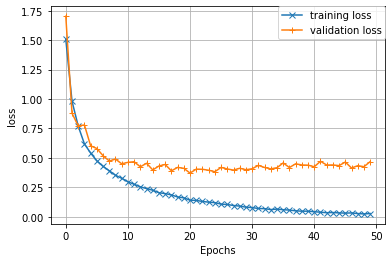

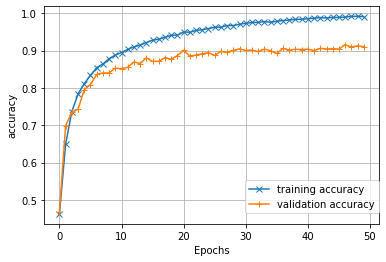

In [10]:
# plot loss

plt.xlabel('Epochs')
plt.ylabel('loss')

plt.plot(epoches,training_losses,"x-",label="training loss")
plt.plot(epoches,validation_losses,"+-",label="validation loss")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

# plot accuracy
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.plot(epoches,training_accuracies,"x-",label="training accuracy")
plt.plot(epoches,validation_accuracies,"+-",label="validation accuracy")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 0.2), loc=1, borderaxespad=0.)

plt.show()


In [11]:
# initialize a numpy array
predictions = np.zeros([10000,2], dtype=int)

id = 0
net.eval()
with torch.no_grad():
    for batch_idx, (inputs) in enumerate(testloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        start_index = batch_idx * VAL_BATCH_SIZE
        for i in range (0, len(predicted)):
            predictions[i + start_index, 0] = i + start_index
            predictions[i + start_index, 1] = predicted.cpu().data[i]
    
# save predictions to file    
np.savetxt('predicted_test.csv',predictions, fmt='%d',delimiter=',',header="Id,Category",comments="")